# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.precompile()

  Activating project at `~/PhD/CMBLensingInferenceTestProblem/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, NPZ, 
    LinearAlgebra, MCMCChains, MCMCDiagnosticTools, MuseInference, MicroCanonicalHMC,
    Plots, ProgressMeter, Random, Statistics, Zygote 

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;
use_map = true
masking = false
t = nothing
precond_path = string("../pixel_preconditioners/pp_nside_", Nside, "_t_", t)
println("Nside: ", Nside)
println("Use Map: ", use_map)
println("Masking: ", masking)


Nside: 64
Use Map: true
Masking: false


In [5]:
prob = load_cmb_lensing_problem(;storage=CuArray, T, Nside,
    masking=masking, global_parameters=true);
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);
cl = get_Cℓ(prob.Ωstart[:ϕ°][:I]);
println("Built problem")

Built problem


In [6]:
# Precond
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

if t == nothing
    precond = one(simulate(Diagonal(one(LenseBasis(diag(prob.Λmass))))));
else
    precond = load(precond_path, "dist_mat_precond")
    precond = adapt(CuArray, precond)
    precond = from_vec(precond);
end
;

In [7]:
#init_params
if use_map
    init_params = prob.Ωtrue
else
    init_params = prob.Ωstart
end
;

# MCHMC

In [8]:
function CMBLensingTarget2(prob)
    θ_start = prob.Ωstart
    d = length(θ_start)
    θ_names = [string("θ_", i) for i=1:d]
    Λmass = prob.Λmass
    sqrtΛmass = sqrt(Λmass)
    inv_sqrtΛmass = pinv(sqrtΛmass)

    function transform(x)
        xt = CMBLensing.LenseBasis(sqrtΛmass * x)
        return xt
    end

    function inv_transform(xt)
        x = CMBLensing.LenseBasis(inv_sqrtΛmass * xt)
        return x
    end

    function ℓπ(xt)
        x = inv_transform(xt)
        return prob(x)
    end

    function ∂lπ∂θ(xt)
        return (ℓπ(xt), CMBLensing.LenseBasis(Zygote.gradient(ℓπ, xt)[1]))
    end

    return MicroCanonicalHMC.Target(
        d,
        MicroCanonicalHMC.Hamiltonian(ℓπ, ∂lπ∂θ),
        transform,
        inv_transform,
        θ_start,
        θ_names)
end
target2 = CMBLensingTarget2(prob);
target = CMBLensingInferenceTestProblem.CMBLensingTarget(prob);

In [9]:
#Sampler
TEV = 0.0001
nadapts = 0
samples = 1_000
L=70.0
spl = MCHMC(nadapts, TEV;
    adaptive=true, eps=0.01, L=L, sigma=precond,
    tune_L=false, tune_sigma=false);

In [10]:
fol_name=string("../chains/", Nside,"/MCHMC/MCHMC",
    "_Nside_", Nside,
    "_use_map_", use_map,
    "_masking_", masking,
    "_precond_", t,
    "_L_", L,
    "_TEV_", TEV)

last_n = 0 
if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/chain_", last_n+1, "_", samples)

Found existing file ../chains/64/MCHMC/MCHMC_Nside_64_use_map_true_masking_false_precond_nothing_L_70.0_TEV_0.0001


"../chains/64/MCHMC/MCHMC_Nside_64_use_map_true_masking_false_precond_nothing_L_70.0_TEV_0.0001/chain_1_1000"

In [31]:
prob.ncalls[] = 0
samples_mchmc = MicroCanonicalHMC.Sample(spl, target, samples; include_latent=true, thinning=20, file_name=file_name)
ncalls_mchmc = prob.ncalls[]

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:20
  ϵ:     35.89493469369773
  dE/d:  -3.7125636595617706e-5


2002

In [32]:
chain_mchmc = Chains(permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]);] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),  [:r, :Aϕ]);

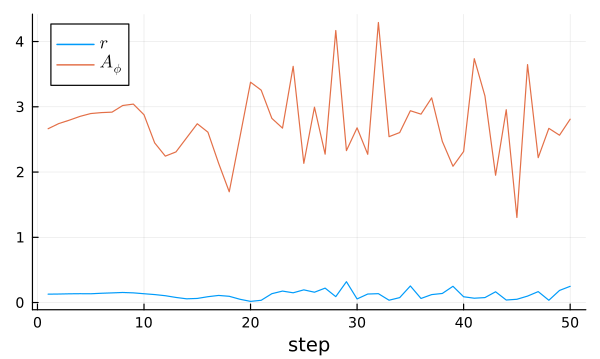

In [42]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(log.(chain_mchmc[:Aϕ]), label=L"A_\phi")

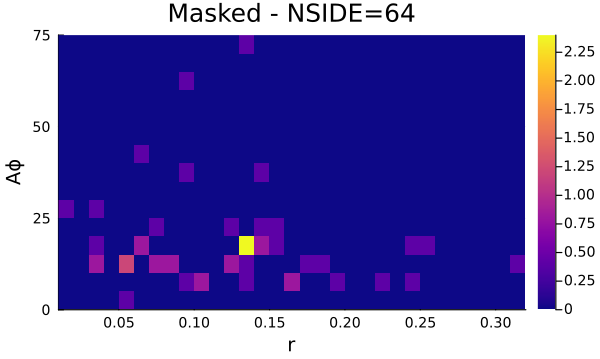

In [34]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

In [35]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

LoadError: ArgumentError: index dE not found

In [16]:
fol_name=string("../summaries/", Nside,"/MCHMC/MCHMC_summary",
    "_Nside_", Nside,
    "_use_map_", use_map,
    "_masking_", masking,
    "_precond_", t,
    "_L_", L,
    "_TEV_", TEV)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("hyperparams", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/hyperparams_", last_n+1, "_", samples)
npzwrite(file_name,
    Dict("r"=> vec(chain_mchmc[:r])[:],
    "Aphi"=> vec(chain_mchmc[:Aϕ])[:])
    

Created new folder ../summaries/64/MCHMC/MCHMC_summary_Nside_64_use_map_true_masking_false_precond_nothing_L_100.0_TEV_0.001


LoadError: syntax: incomplete: premature end of input

In [17]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f062a1beef0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


LoadError: InvalidIRError: compiling MethodInstance for GPUArrays.getindex_kernel(::CUDA.CuKernelContext, ::CuDeviceVector{Float64, 1}, ::CuDeviceVector{Float64, 1}, ::Tuple{Int64}, ::CuDeviceVector{Union{Nothing, Int64}, 1}) resulted in invalid LLVM IR
[31mReason: unsupported dynamic function invocation[39m[31m (call to var"#sprint#484"([90mcontext[39m, [90msizehint[39m::[1mInteger[22m, ::[1mtypeof(sprint)[22m, [90mf[39m::[1mFunction[22m, [90margs...[39m)[90m @[39m [90mBase[39m [90mstrings/[39m[90m[4mio.jl:107[24m[39m)[39m
Stacktrace:
  [1] [0m[1msprint[22m
[90m    @[39m [90m./strings/[39m[90m[4mio.jl:107[24m[39m
  [2] [0m[1m#repr#487[22m
[90m    @[39m [90m./strings/[39m[90m[4mio.jl:282[24m[39m
  [3] [0m[1mrepr[22m
[90m    @[39m [90m./strings/[39m[90m[4mio.jl:282[24m[39m
  [4] [0m[1mlimitrepr[22m
[90m    @[39m [90m./strings/[39m[90m[4mio.jl:284[24m[39m
  [5] [0m[1mto_index[22m
[90m    @[39m [90m./[39m[90m[4mindices.jl:300[24m[39m
  [6] [0m[1mto_index[22m
[90m    @[39m [90m./[39m[90m[4mindices.jl:277[24m[39m
  [7] [0m[1m_to_indices1[22m
[90m    @[39m [90m./[39m[90m[4mindices.jl:359[24m[39m
  [8] [0m[1mto_indices[22m
[90m    @[39m [90m./[39m[90m[4mindices.jl:354[24m[39m
  [9] [0m[1mto_indices[22m
[90m    @[39m [90m./[39m[90m[4mindices.jl:345[24m[39m
 [10] [0m[1mgetindex[22m
[90m    @[39m [90m./[39m[90m[4mabstractarray.jl:1296[24m[39m
 [11] [0m[1mmacro expansion[22m
[90m    @[39m [90m~/.julia/packages/GPUArrays/5XhED/src/host/[39m[90m[4mindexing.jl:58[24m[39m
 [12] [0m[1mgetindex_kernel[22m
[90m    @[39m [90m~/.julia/packages/GPUArrays/5XhED/src/host/[39m[90m[4mindexing.jl:52[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to print)[39m
Stacktrace:
 [1] [0m[1mprint_to_string[22m
[90m   @[39m [90m./strings/[39m[90m[4mio.jl:144[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_grow_end)[39m
Stacktrace:
 [1] [0m[1m_growend![22m
[90m   @[39m [90m./[39m[90m[4marray.jl:1014[24m[39m
 [2] [0m[1mresize![22m
[90m   @[39m [90m./[39m[90m[4marray.jl:1249[24m[39m
 [3] [0m[1mprint_to_string[22m
[90m   @[39m [90m./strings/[39m[90m[4mio.jl:146[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_del_end)[39m
Stacktrace:
 [1] [0m[1m_deleteend![22m
[90m   @[39m [90m./[39m[90m[4marray.jl:1023[24m[39m
 [2] [0m[1mresize![22m
[90m   @[39m [90m./[39m[90m[4marray.jl:1254[24m[39m
 [3] [0m[1mprint_to_string[22m
[90m   @[39m [90m./strings/[39m[90m[4mio.jl:146[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_array_to_string)[39m
Stacktrace:
 [1] [0m[1mString[22m
[90m   @[39m [90m./strings/[39m[90m[4mstring.jl:67[24m[39m
 [2] [0m[1mprint_to_string[22m
[90m   @[39m [90m./strings/[39m[90m[4mio.jl:146[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_alloc_string)[39m
Stacktrace:
 [1] [0m[1m_string_n[22m
[90m   @[39m [90m./strings/[39m[90m[4mstring.jl:90[24m[39m
 [2] [0m[1mStringVector[22m
[90m   @[39m [90m./[39m[90m[4miobuffer.jl:31[24m[39m
 [3] [0m[1m#IOBuffer#454[22m
[90m   @[39m [90m./[39m[90m[4miobuffer.jl:114[24m[39m
 [4] [0m[1mGenericIOBuffer[22m
[90m   @[39m [90m./[39m[90m[4miobuffer.jl:105[24m[39m
 [5] [0m[1mprint_to_string[22m
[90m   @[39m [90m./strings/[39m[90m[4mio.jl:142[24m[39m
[31mReason: unsupported call through a literal pointer[39m[31m (call to ijl_string_to_array)[39m
Stacktrace:
 [1] [0m[1munsafe_wrap[22m
[90m   @[39m [90m./strings/[39m[90m[4mstring.jl:100[24m[39m
 [2] [0m[1mStringVector[22m
[90m   @[39m [90m./[39m[90m[4miobuffer.jl:31[24m[39m
 [3] [0m[1m#IOBuffer#454[22m
[90m   @[39m [90m./[39m[90m[4miobuffer.jl:114[24m[39m
 [4] [0m[1mGenericIOBuffer[22m
[90m   @[39m [90m./[39m[90m[4miobuffer.jl:105[24m[39m
 [5] [0m[1mprint_to_string[22m
[90m   @[39m [90m./strings/[39m[90m[4mio.jl:142[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl[39m

In [18]:
ess_per_call_mchmc = minimum(ess_mchmc ./ samples) #ncalls_mchmc

LoadError: UndefVarError: `ess_mchmc` not defined

In [ ]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d];

In [ ]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2);

In [ ]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
plot!(vars, label=string("Parameter space --> K = ", k))

# HMC

In [ ]:
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
ϵ=0.05
samples = 10
@showprogress for i=1:samples
    Ω, = state = hmc_step(rng, prob, init_params, prob.Λmass; symp_kwargs=[(N=25, ϵ=ϵ)], progress=false, always_accept=(i<10))
    push!(samples_hmc, adapt(Array, state))
end
ncalls_hmc = prob.ncalls[]

In [ ]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

In [ ]:
_samples_hmc = zeros(samples, 3*Nside^2+2)
for i in 1:samples
    _samples_hmc[i, :]  = samples_hmc[i][1][:]
end
_samples_hmc

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/", Nside, "/HMC/CMBLensing",
    "_use_map_", use_map,
    "_masking_", masking,
    "_Nside_", Nside,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
        last_chain = load(string(fol_name, "/", last_chain), "samples")
        init_params = last_chain[:, end]
        println("Restarting chain")
    else
        println("Starting new chain")
        last_n = 0
        init_params = prob.Ωstart
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
    last_n = 0
end

file_name = string(fol_name, "/chain_", last_n+1, "_", samples)

@save file_name _samples_hmc

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/summaries/", Nside,"/HMC/HMC_summary",
    "_use_map_", use_map,
    "_masking_", masking,
    "_Nside_", Nside,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("hyperparams", file)])
        last_n = parse(Int, last_chain[end])
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
end

file_name = string(fol_name, "/hyperparams_", last_n+1, "_", samples)
npzwrite(file_name,
    Dict("r"=> vec(chain_hmc[:r])[:],
    "Aphi"=> vec(chain_hmc[:Aϕ])[:])

In [ ]:
#samples_hmc = load("../chains/HMC/CMBLensing_masked_Nnside_64_ϵ_0.25", "_samples_hmc")

In [ ]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

## Plot

In [ ]:
plot(getindex.(samples_hmc, 2), label=nothing, xlabel="step", ylabel=L"\Delta H")     

In [ ]:
samples_hmc[end][1][:ϕ°][:]

In [ ]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(samples_hmc[end][1][k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)
     


In [ ]:
plot([exp(Ω.θ.r) for (Ω,) in samples_hmc], label=L"r", xlabel="step")
plot!([exp(Ω.θ.Aϕ) for (Ω,) in samples_hmc], label=L"A_\phi")     


In [ ]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

In [ ]:
ess_per_call_hmc = ess_hmc ./ (ncalls_hmc/2)

In [ ]:
ess_per_call_hmc = minimum(ess_hmc ./ (ncalls_hmc/2))

In [ ]:
histogram2d(chain_hmc[:r], chain_hmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!(string("Masked: ", masking, "- NSIDE=", Nside))
ylabel!("Aϕ")
xlabel!("r")

# MUSE

In [ ]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [ ]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [ ]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseInferenceExt.CMBLensingMuseProblem, θ) = exp.(θ)

In [ ]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [ ]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

In [ ]:
chain_muse = Chains(permutedims(rand(result.dist,5_000)), [:logr, :logAϕ]);

In [ ]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/", Nside, "/MUSE/CMBLensing",
    "_cosmo_", global_parameters,
    "_masking_", masking,
    "_Nside_", Nside)
@save fol_name chain_muse

In [ ]:
#chain_muse = load("../chains/MUSE/CMBLensing_masked_Nnside_64", "chain_muse")

In [ ]:
ess_per_call_muse = nsims / ncalls_muse

## Plot

# Compare

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

In [ ]:
ess_per_call_mchmc

In [ ]:
ess_per_call_hmc

In [ ]:
ess_per_call_muse

In [ ]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

In [ ]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)